In [6]:
"""
Fixed and hardened Synthetic demand data generator for ML forecasting (Turkey).
This updated version includes debug checks to ensure all products are generated and
prints a per-product count summary. It also sorts the final CSV by date & product_id
so each day contains rows for all products.

How this fixes your issue:
- Ensures the random generator (`rng`) is created before we pre-generate campaigns.
- Generates campaigns inside `build_dataframe` using the same `rng` object.
- Adds assertions and debugging prints that will reveal if any product is missing.
- Saves output sorted by date then product_id.

Run the script and check the printed product counts. If any are missing, the debug
print will show which products were produced and which were expected.
"""
from __future__ import annotations
import numpy as np
import pandas as pd
from datetime import date, timedelta

# ----------------------- Configuration -----------------------
START = date(2023, 1, 1)
END   = date(2025, 12, 31)

PRODUCTS = [
    (0, "sunscreen"),
    (1, "notebook"),
    (2, "candy"),
    (3, "flowers"),
    (4, "dates"),   # hurma (spikes during Ramadan)
    (5, "coat"),
    (6, "ice_cream"),
    (7, "tea"),
]

# Typical base daily sales
BASE_DEMAND = {
    "sunscreen": 18,
    "notebook": 12,
    "candy": 25,
    "flowers": 10,
    "dates": 8,
    "coat": 7,
    "ice_cream": 20,
    "tea": 30,
}

# Monthly seasonality multipliers per product
MONTHLY_SEASON = {
    "sunscreen":  {1:0.6,2:0.6,3:0.7,4:0.9,5:1.4,6:2.0,7:2.2,8:2.0,9:1.2,10:0.8,11:0.6,12:0.6},
    "notebook":   {1:0.8,2:0.9,3:1.0,4:1.0,5:1.0,6:1.0,7:0.9,8:1.1,9:2.5,10:2.0,11:1.1,12:0.9},
    "candy":      {1:1.0,2:1.0,3:1.0,4:1.1,5:1.1,6:1.2,7:1.1,8:1.0,9:1.0,10:1.0,11:1.1,12:1.5},
    "flowers":    {1:1.0,2:2.0,3:1.6,4:1.3,5:2.5,6:1.1,7:1.0,8:1.0,9:1.0,10:1.0,11:1.1,12:1.6},
    "dates":      {1:1.0,2:1.0,3:1.0,4:1.2,5:1.2,6:1.0,7:1.0,8:1.0,9:1.0,10:1.0,11:1.0,12:1.0},
    "coat":       {1:2.0,2:2.2,3:1.8,4:1.3,5:0.9,6:0.6,7:0.5,8:0.6,9:1.0,10:1.6,11:2.2,12:2.4},
    "ice_cream":  {1:0.5,2:0.5,3:0.6,4:0.9,5:1.6,6:2.2,7:2.5,8:2.3,9:1.4,10:0.9,11:0.6,12:0.5},
    "tea":        {1:1.6,2:1.5,3:1.4,4:1.2,5:1.0,6:0.9,7:0.9,8:0.9,9:1.0,10:1.1,11:1.3,12:1.5},
}

# Day-of-week effects (0=Mon..6=Sun)
DOW_EFFECT = np.array([0.95, 0.98, 1.0, 1.02, 1.05, 1.2, 1.25])

# Campaign parameters and discount ranges
CAMPAIGN_PARAMS = {
    "sunscreen":  dict(lambda_per_year=3, duration=(7, 21), ptypes=[0.6, 0.3, 0.1]),
    "notebook":   dict(lambda_per_year=3, duration=(7, 21), ptypes=[0.5, 0.4, 0.1]),
    "candy":      dict(lambda_per_year=4, duration=(5, 12), ptypes=[0.5, 0.3, 0.2]),
    "flowers":    dict(lambda_per_year=4, duration=(3, 7),  ptypes=[0.6, 0.3, 0.1]),
    "dates":      dict(lambda_per_year=2, duration=(10, 20), ptypes=[0.5, 0.3, 0.2]),
    "coat":       dict(lambda_per_year=2, duration=(10, 25), ptypes=[0.6, 0.3, 0.1]),
    "ice_cream":  dict(lambda_per_year=3, duration=(7, 21), ptypes=[0.6, 0.3, 0.1]),
    "tea":        dict(lambda_per_year=2, duration=(7, 14),  ptypes=[0.5, 0.3, 0.2]),
}

DISCOUNT_BY_TYPE = {
    -1: (0.0, 0.0),
    0:  (0.10, 0.50),
    1:  (0.05, 0.20),
    2:  (0.02, 0.10),
}

# Holidays
FIXED_PUBLIC = [
    (1, 1, "Yılbaşı"),
    (4, 23, "23 Nisan Ulusal Egemenlik ve Çocuk Bayramı"),
    (5, 1, "Emek ve Dayanışma Günü"),
    (5, 19, "Atatürk'ü Anma, Gençlik ve Spor Bayramı"),
    (7, 15, "Demokrasi ve Milli Birlik Günü"),
    (8, 30, "Zafer Bayramı"),
    (10, 29, "Cumhuriyet Bayramı"),
]

RAMAZAN_BAYRAMI = {
    2023: (date(2023, 4, 21), date(2023, 4, 23)),
    2024: (date(2024, 4, 10), date(2024, 4, 12)),
    2025: (date(2025, 3, 31), date(2025, 4, 2)),
}
KURBAN_BAYRAMI = {
    2023: (date(2023, 6, 28), date(2023, 7, 1)),
    2024: (date(2024, 6, 16), date(2024, 6, 19)),
    2025: (date(2025, 6, 6), date(2025, 6, 9)),
}

RAMAZAN_MONTH = {
    2023: (date(2023, 3, 23), date(2023, 4, 20)),
    2024: (date(2024, 3, 10), date(2024, 4, 8)),
    2025: (date(2025, 2, 28), date(2025, 3, 29)),
}

VALENTINES = (2, 14, "Sevgililer Günü")
WOMENS_DAY = (3, 8, "Dünya Kadınlar Günü")
MOTHERS_DAY_NAME = "Anneler Günü"
FATHERS_DAY_NAME = "Babalar Günü"
NEW_YEARS_EVE = (12, 31, "Yılbaşı Arifesi")
BACK_TO_SCHOOL = "Okula Dönüş"


def daterange(d0: date, d1: date):
    cur = d0
    while cur <= d1:
        yield cur
        cur += timedelta(days=1)


def build_holiday_map(start: date, end: date) -> dict[date, tuple[str,int]]:
    hol = {}
    for y in range(start.year, end.year + 1):
        for m, d, name in FIXED_PUBLIC:
            hol[date(y, m, d)] = (name, 1)
    for y, (s, e) in RAMAZAN_BAYRAMI.items():
        for dt in daterange(s, e):
            hol[dt] = ("Ramazan Bayramı", 1)
    for y, (s, e) in KURBAN_BAYRAMI.items():
        for dt in daterange(s, e):
            hol[dt] = ("Kurban Bayramı", 1)
    for y in range(start.year, end.year + 1):
        hol[date(y, VALENTINES[0], VALENTINES[1])] = (VALENTINES[2], 0)
        hol[date(y, WOMENS_DAY[0], WOMENS_DAY[1])] = (WOMENS_DAY[2], 0)
        hol[date(y, NEW_YEARS_EVE[0], NEW_YEARS_EVE[1])] = (NEW_YEARS_EVE[2], 0)
        # Mothers' Day: second Sunday of May
        may1 = date(y, 5, 1)
        mothers = next(d for d in daterange(may1, date(y, 5, 14)) if d.weekday() == 6)
        hol[mothers] = (MOTHERS_DAY_NAME, 0)
        # Fathers' Day: third Sunday of June
        jun1 = date(y, 6, 1)
        sundays_jun = [d for d in daterange(jun1, date(y, 6, 30)) if d.weekday() == 6]
        if len(sundays_jun) >= 3:
            hol[sundays_jun[2]] = (FATHERS_DAY_NAME, 0)
    return hol

HOLIDAYS = build_holiday_map(START, END)

EVENT_BOOSTS = {
    "sunscreen": {"Ramazan Bayramı": 1.0, "Kurban Bayramı": 1.0, "Yılbaşı": 0.9, "Yılbaşı Arifesi": 0.9},
    "notebook":  {BACK_TO_SCHOOL: 2.0},
    "candy":     {"Ramazan Bayramı": 2.5, "Kurban Bayramı": 1.6, "Yılbaşı": 1.4},
    "flowers":   {"Sevgililer Günü": 3.5, MOTHERS_DAY_NAME: 3.0, WOMENS_DAY[2]: 1.6, "Yılbaşı": 1.3},
    "dates":     {"Ramazan Bayramı": 1.6},
    "coat":      {"Yılbaşı": 1.3},
    "ice_cream": {"Yılbaşı": 0.8},
    "tea":       {"Yılbaşı": 1.2},
}

BTS_WINDOWS = [(9, 1), (10, 15)]


def is_in_ramadan_month(dt: date) -> bool:
    rng = RAMAZAN_MONTH.get(dt.year)
    return rng[0] <= dt <= rng[1] if rng else False


def gen_campaigns_for_year(product: str, year: int, rng: np.random.Generator):
    params = CAMPAIGN_PARAMS[product]
    lam = params["lambda_per_year"]
    n = int(rng.poisson(lam))
    duration_low, duration_high = params["duration"]
    ptypes = params["ptypes"]

    windows = []
    tries = 0
    while len(windows) < n and tries < 2000:
        tries += 1
        start_doy = int(rng.integers(0, 365))
        start = date(year, 1, 1) + timedelta(days=start_doy)
        dur = int(rng.integers(duration_low, duration_high + 1))
        end = min(start + timedelta(days=dur - 1), date(year, 12, 31))
        ctype = int(rng.choice([0,1,2], p=ptypes))
        if any(not (end < s or start > e) for s, e, _ in windows):
            continue
        windows.append((start, end, ctype))
    return windows


def discount_for_type(ctype: int, rng: np.random.Generator) -> float:
    lo, hi = DISCOUNT_BY_TYPE[ctype]
    return float(rng.uniform(lo, hi))


def build_dataframe(seed: int = 42, verbose: bool = True) -> pd.DataFrame:
    rng = np.random.default_rng(seed)

    dates = list(daterange(START, END))
    records = []

    # Pre-generate campaigns using the same rng
    campaigns = {p: {y: gen_campaigns_for_year(p, y, rng) for y in range(START.year, END.year + 1)} for _, p in PRODUCTS}

    # Consumer Confidence Index (CCI): AR(1)
    cci = {}
    phi = 0.95
    sigma = 0.6
    prev = 100.0
    for dt in dates:
        shock = rng.normal(0, sigma)
        val = 100 + phi * (prev - 100) + shock
        val = float(np.clip(val, 95, 115))
        cci[dt] = val
        prev = val

    for pid, pname in PRODUCTS:
        if pname not in BASE_DEMAND:
            raise KeyError(f"Product '{pname}' is missing BASE_DEMAND entry")
        base = BASE_DEMAND[pname]
        trend_rate = {"notebook": 0.02, "ice_cream": 0.02, "tea": 0.01, "coat": -0.01}.get(pname, 0.0)

        for dt in dates:
            month = dt.month
            dow = dt.weekday()
            season = MONTHLY_SEASON[pname][month]

            bts = (dt >= date(dt.year, BTS_WINDOWS[0][0], BTS_WINDOWS[0][1])) and \
                  (dt <= date(dt.year, BTS_WINDOWS[1][0], BTS_WINDOWS[1][1]))

            holiday_name, holiday_type = HOLIDAYS.get(dt, ("", 0))
            if holiday_type != 1 and dt.weekday() >= 5:
                holiday_type = 2

            event_mult = 1.0
            if holiday_name:
                event_mult *= EVENT_BOOSTS.get(pname, {}).get(holiday_name, 1.0)
            if pname == "notebook" and bts:
                event_mult *= EVENT_BOOSTS["notebook"][BACK_TO_SCHOOL]
            if pname == "dates" and is_in_ramadan_month(dt):
                event_mult *= 2.5
            if pname == "candy" and is_in_ramadan_month(dt):
                event_mult *= 1.3

            dow_mult = DOW_EFFECT[dow]

            cy = dt.year
            active_campaign = next(((s, e, t) for (s, e, t) in campaigns[pname][cy] if s <= dt <= e), None)
            if active_campaign is None:
                campaign_type = -1
                discount_ratio = 0.0
                campaign_duration = 0
                campaign_uplift = 1.0
            else:
                s, e, campaign_type = active_campaign
                discount_ratio = discount_for_type(campaign_type, rng)
                campaign_duration = (e - s).days + 1
                sens = {"sunscreen": 1.1, "notebook": 1.2, "candy": 0.9, "flowers": 1.5,
                        "dates": 0.8, "coat": 1.3, "ice_cream": 1.1, "tea": 0.7}[pname]
                campaign_uplift = 1.0 + sens * (discount_ratio ** 0.8)

            cci_elast = 0.6
            cci_mult = (cci[dt] / 100.0) ** cci_elast

            years_since_start = (dt - START).days / 365.25
            trend_mult = (1.0 + trend_rate) ** years_since_start

            eps = float(np.exp(rng.normal(0, 0.15)))

            demand = base * season * dow_mult * event_mult * campaign_uplift * cci_mult * trend_mult * eps
            demand = int(max(0, round(demand)))

            records.append({
                "date": dt,
                "product_id": pid,
                "product_name": pname,
                "demand": demand,
                "campaign_type": campaign_type,
                "discount_ratio": round(discount_ratio, 3),
                "campaign_duration": campaign_duration,
                "holiday_name": holiday_name,
                "holiday_type": holiday_type,
                "consumer_confidence_index": round(cci[dt], 2),
            })

    df = pd.DataFrame.from_records(records)

    # Debug / sanity checks
    expected_rows = len(dates) * len(PRODUCTS)
    if len(df) != expected_rows:
        # print helpful diagnostics
        produced = df["product_name"].unique().tolist()
        counts = df["product_name"].value_counts().to_dict()
        missing = [p for _, p in PRODUCTS if p not in produced]
        msg = (
            f"Sanity check failed: expected {expected_rows} rows (dates x products) but got {len(df)}."
            f"Produced products: {produced} Counts: {counts} Missing products: {missing}"
        )
        raise RuntimeError(msg)

    if verbose:
        print("Per-product counts:")
        print(df["product_name"].value_counts())

    return df


if __name__ == "__main__":
    df = build_dataframe(seed=2025, verbose=True)
    # Sort by date then product so each day shows all products
    df = df.sort_values(["date", "product_id"]).reset_index(drop=True)

    # Quick checks you can run interactively
    print('Unique products in dataset:', df['product_name'].unique())
    print('Sample rows:')
    print(df.head(16))

    out_path = "synthetic_demand_tr_TR_2023_2025_fixed.csv"
    df.to_csv(out_path, index=False)
    print(f"Saved {len(df):,} rows to {out_path}")


Per-product counts:
product_name
sunscreen    1096
notebook     1096
candy        1096
flowers      1096
dates        1096
coat         1096
ice_cream    1096
tea          1096
Name: count, dtype: int64
Unique products in dataset: ['sunscreen' 'notebook' 'candy' 'flowers' 'dates' 'coat' 'ice_cream' 'tea']
Sample rows:
          date  product_id product_name  demand  campaign_type  \
0   2023-01-01           0    sunscreen      11             -1   
1   2023-01-01           1     notebook      11             -1   
2   2023-01-01           2        candy      52             -1   
3   2023-01-01           3      flowers      13             -1   
4   2023-01-01           4        dates       9             -1   
5   2023-01-01           5         coat      22             -1   
6   2023-01-01           6    ice_cream       8             -1   
7   2023-01-01           7          tea      76             -1   
8   2023-01-02           0    sunscreen       9             -1   
9   2023-01-02      

In [3]:
df = pd.read_csv("synthetic_demand_tr_TR_2023_2025_fixed.csv")
df.head()

,date,product_id,product_name,demand,campaign_type,discount_ratio,campaign_duration,holiday_name,holiday_type,consumer_confidence_index
0,2023-01-01,0,sunscreen,11,-1,0.0,0,Yılbaşı,1,100.1
1,2023-01-01,1,notebook,11,-1,0.0,0,Yılbaşı,1,100.1
2,2023-01-01,2,candy,52,-1,0.0,0,Yılbaşı,1,100.1
3,2023-01-01,3,flowers,13,-1,0.0,0,Yılbaşı,1,100.1
4,2023-01-01,4,dates,9,-1,0.0,0,Yılbaşı,1,100.1


In [2]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Dense, Dropout
from statsmodels.tsa.statespace.sarimax import SARIMAX

C:\Users\kupa-\anaconda3\envs\DeepLearning1\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [28]:
#XGBoost Model

In [21]:
HORIZON = 7  # forecast 7 days ahead
LAGS = 14    # use last 14 days to predict next 7

def create_lag_features(df, product_name, lags=LAGS, horizon=HORIZON):
    df_prod = df[df['product_name'] == product_name].copy()
    df_prod = df_prod.sort_values('date')
    
    # Lag features for demand
    for lag in range(1, lags+1):
        df_prod[f'demand_lag_{lag}'] = df_prod['demand'].shift(lag)
    
    # Exogenous features (shifted 0 because known today)
    exog_cols = ['campaign_type', 'discount_ratio', 'campaign_duration', 
                 'holiday_type', 'consumer_confidence_index']
    
    # Targets: next 7 days
    for h in range(1, horizon+1):
        df_prod[f'target_t+{h}'] = df_prod['demand'].shift(-h)
    
    df_prod = df_prod.dropna()
    X = df_prod[[f'demand_lag_{lag}' for lag in range(1, lags+1)] + exog_cols]
    Y = df_prod[[f'target_t+{h}' for h in range(1, horizon+1)]]
    return X, Y

In [22]:
X, Y = create_lag_features(df, 'tea', lags=LAGS, horizon=HORIZON)

# last 30 days as test
X_train, X_test = X[:-30], X[-30:]
Y_train, Y_test = Y[:-30], Y[-30:]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(23, 19) (23, 7)
(30, 19) (30, 7)


In [25]:
models = []
preds = pd.DataFrame(index=Y_test.index)

for h in range(HORIZON):
    model = XGBRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42
    )
    model.fit(X_train, Y_train.iloc[:, h])
    y_pred = model.predict(X_test)
    preds[f'target_t+{h+1}'] = y_pred
    models.append(model)

    rmse = np.sqrt(mean_squared_error(Y_test.iloc[:, h], y_pred))
    print(f'RMSE t+{h+1}: {rmse:.2f}')

RMSE t+1: 6.93
RMSE t+2: 10.05
RMSE t+3: 11.07
RMSE t+4: 9.76
RMSE t+5: 9.49
RMSE t+6: 7.44
RMSE t+7: 13.30


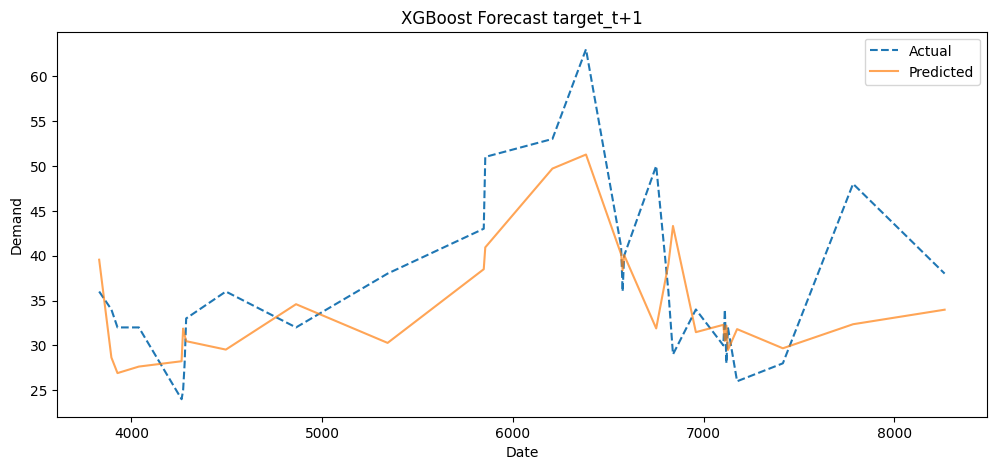

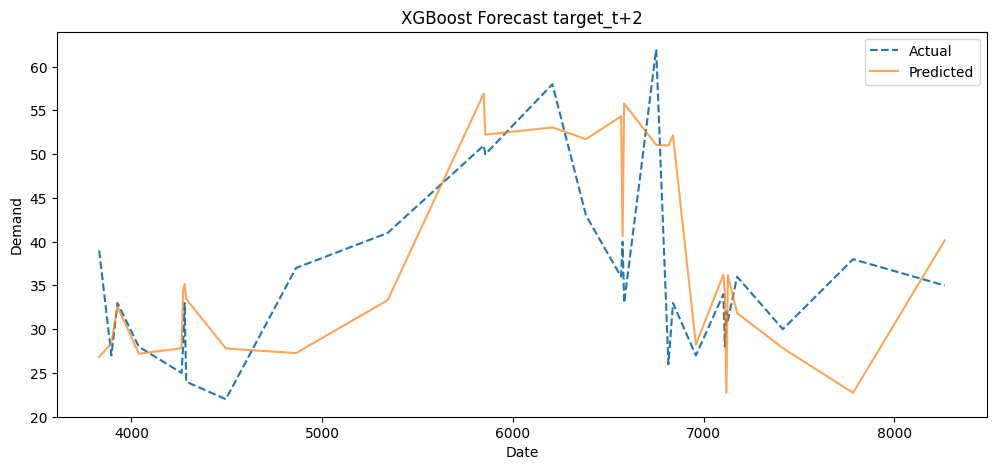

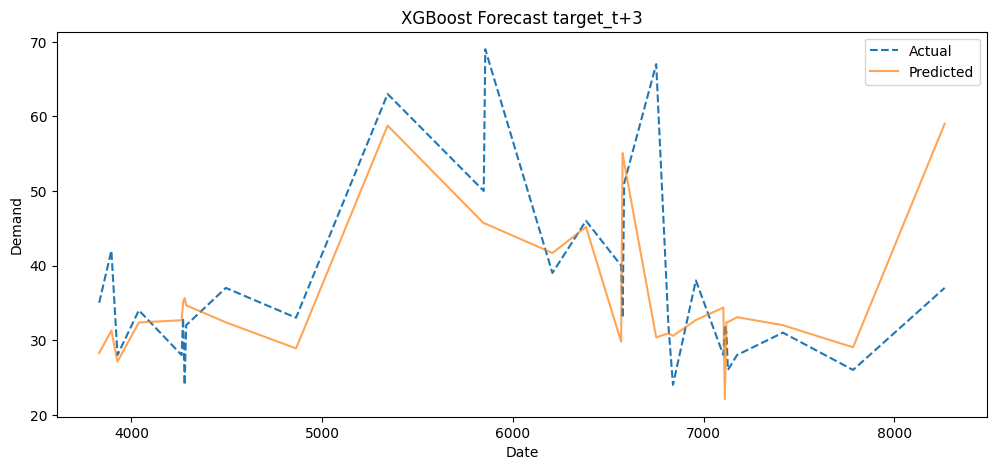

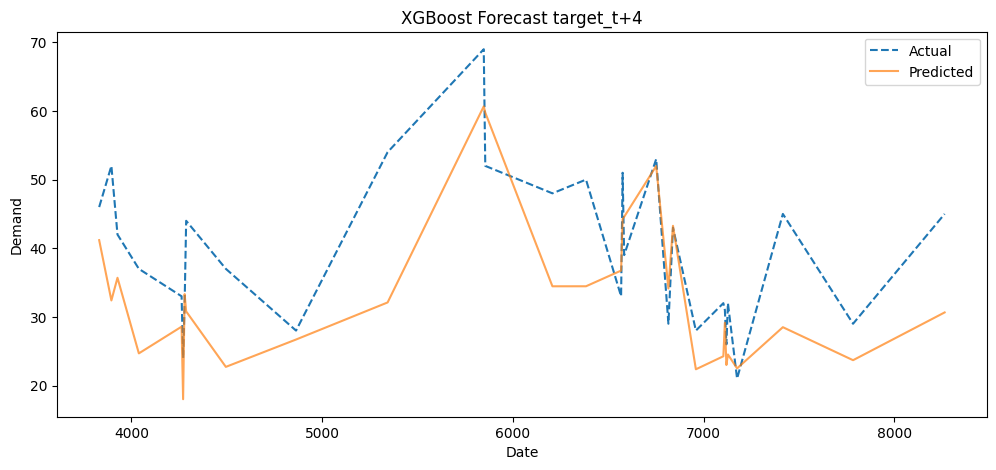

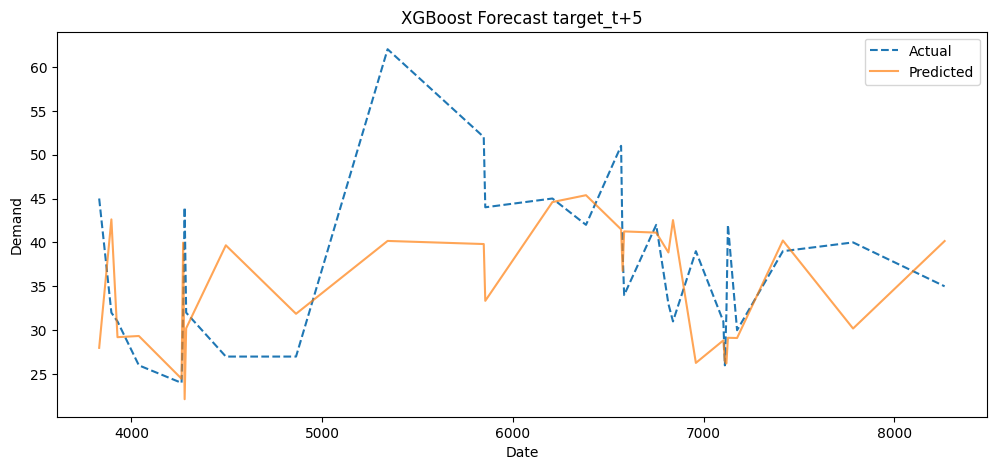

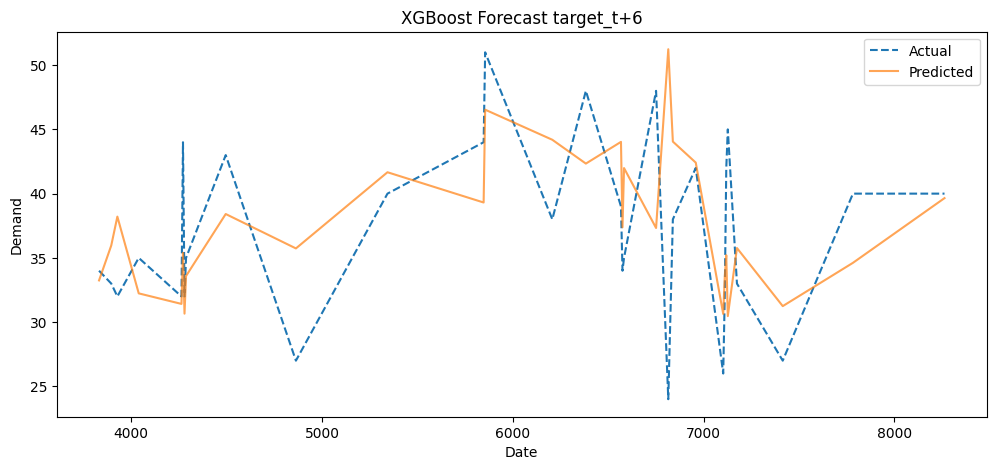

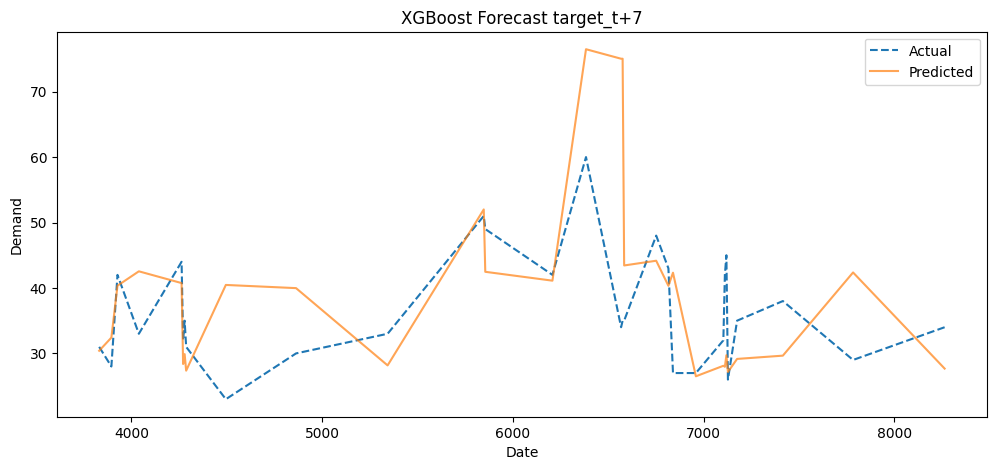

In [26]:
for h in range(HORIZON):
    col = f'target_t+{h+1}'
    plt.figure(figsize=(12,5))
    plt.plot(Y_test.index, Y_test[col], linestyle='--', label='Actual')
    plt.plot(preds.index, preds[col], alpha=0.7, label='Predicted')
    plt.title(f'XGBoost Forecast {col}')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.show()

In [29]:
#SARIMAX Model

In [30]:
product = 'tea'
df_prod = df[df['product_name'] == product].sort_values('date')

In [34]:
df_prod = df_prod.sort_values('date')
df_prod = df_prod.set_index('date')  # make date the index

In [31]:
# Use 'demand' as endog, exogenous variables as exog
endog = df_prod['demand']
exog_cols = ['campaign_type', 'discount_ratio', 'campaign_duration', 
             'holiday_type', 'consumer_confidence_index']
exog = df_prod[exog_cols]

In [35]:
endog = df_prod['demand']
exog = df_prod[exog_cols]

In [36]:
# Train/test split (last 30 days)
train_endog, test_endog = endog[:-30], endog[-30:]
train_exog, test_exog = exog[:-30], exog[-30:]

In [37]:
# Fit SARIMAX model (example seasonal order: weekly seasonality)
model = SARIMAX(train_endog,
                exog=train_exog,
                order=(1,1,1),
                seasonal_order=(1,1,1,7),
                enforce_stationarity=False,
                enforce_invertibility=False)
sarimax_res = model.fit(disp=False)

C:\Users\kupa-\anaconda3\envs\DeepLearning1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kupa-\anaconda3\envs\DeepLearning1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kupa-\anaconda3\envs\DeepLearning1\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
# Forecast 7 days recursively
horizon = 7
preds = []
history_endog = train_endog.copy()
history_exog = train_exog.copy()


In [48]:
preds = sarimax_res.get_forecast(steps=len(test_endog), exog=test_exog)
y_pred = preds.predicted_mean  # now y_pred.shape == test_endog.shape

In [49]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_endog, y_pred))
print(f"SARIMAX RMSE: {rmse:.2f}")

SARIMAX RMSE: 8.01


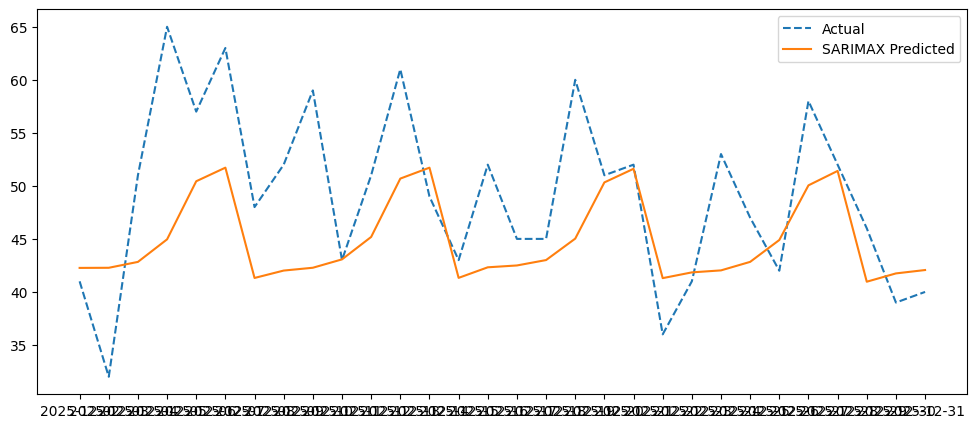

In [51]:
# Plot
plt.figure(figsize=(12,5))
plt.plot(test_endog.index, test_endog.values, linestyle='--', label='Actual')
plt.plot(test_endog.index, y_pred.values, label='SARIMAX Predicted')
plt.legend()
plt.show()

In [4]:
#LSTM Model

In [28]:
df.head()

,date,product_id,product_name,demand,campaign_type,discount_ratio,campaign_duration,holiday_name,holiday_type,consumer_confidence_index
0,2023-01-01,0,sunscreen,11,-1,0.0,0,Yılbaşı,1,100.1
1,2023-01-01,1,notebook,11,-1,0.0,0,Yılbaşı,1,100.1
2,2023-01-01,2,candy,52,-1,0.0,0,Yılbaşı,1,100.1
3,2023-01-01,3,flowers,13,-1,0.0,0,Yılbaşı,1,100.1
4,2023-01-01,4,dates,9,-1,0.0,0,Yılbaşı,1,100.1


In [29]:
# --- Prepare data ---
product_id = 0
product_df = df[df["product_id"] == product_id].set_index("date")


In [30]:
# Features
features = ["campaign_type", "discount_ratio", "campaign_duration",
            "holiday_type", "consumer_confidence_index"]
target = "demand"

In [31]:
#Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(product_df[features])
y_scaled = scaler_y.fit_transform(product_df[[target]])

In [32]:
def create_sequences(X, y, seq_length=14, horizon=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length - horizon + 1):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length:i+seq_length+horizon])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 14  # look-back 14 days
HORIZON = 7      # predict next 7 days

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH, HORIZON)

In [33]:
# TRAIN/TEST SPLIT
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [34]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(Dense(HORIZON))
model.compile(optimizer='adam', loss='mse')

C:\Users\kupa-\anaconda3\envs\DeepLearning1\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
# TRAIN MODEL
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_split=0.1, verbose=1)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0607 - val_loss: 0.0229
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0451 - val_loss: 0.0393
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0437 - val_loss: 0.0500
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0417 - val_loss: 0.0864
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0417 - val_loss: 0.0674
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0402 - val_loss: 0.0543
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0407 - val_loss: 0.1217
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0391 - val_loss: 0.0772
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0389 - val_loss: 0.1050
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0393 - val_loss: 0.0878
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0381 - val_loss: 0.1213
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

In [36]:
#prediction
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, HORIZON))

y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, HORIZON))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


In [38]:
# Compute RMSE per horizon step
for i in range(HORIZON):
    rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred[:, i]))
    print(f"RMSE t+{i+1}: {rmse:.2f}")

RMSE t+1: 17.02
RMSE t+2: 17.26
RMSE t+3: 17.66
RMSE t+4: 17.74
RMSE t+5: 17.82
RMSE t+6: 17.79
RMSE t+7: 17.51


In [42]:
# --- Predict ---
for i in range(HORIZON):
    rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred[:, i]))
    df_compare = pd.DataFrame({
        "Actual": y_test_actual[:, i],
        "Predicted": y_pred[:, i]
    })
    print(f"\nHorizon t+{i+1} | RMSE: {rmse:.2f}")
    print(df_compare.head(10))


Horizon t+1 | RMSE: 17.02
   Actual  Predicted
0    26.0  27.717628
1    35.0  28.044348
2    20.0  19.074602
3    28.0  17.748043
4    26.0  18.312477
5    24.0  20.081377
6    24.0  22.868580
7    25.0  25.988287
8    40.0  22.547932
9    40.0  18.293245

Horizon t+2 | RMSE: 17.26
   Actual  Predicted
0    35.0  28.470583
1    20.0  25.581598
2    28.0  17.462315
3    26.0  18.825544
4    24.0  20.032627
5    24.0  21.441702
6    25.0  23.380821
7    40.0  25.393084
8    40.0  19.789684
9    33.0  16.302834

Horizon t+3 | RMSE: 17.66
   Actual  Predicted
0    20.0  27.568985
1    28.0  25.485571
2    26.0  20.141285
3    24.0  22.035004
4    24.0  21.947779
5    25.0  21.916172
6    40.0  22.562563
7    40.0  23.481979
8    33.0  19.686247
9    38.0  18.343330

Horizon t+4 | RMSE: 17.74
   Actual  Predicted
0    28.0  25.248928
1    26.0  24.287804
2    24.0  20.771511
3    24.0  22.395048
4    25.0  21.830559
5    40.0  21.289917
6    40.0  21.258360
7    33.0  21.550406
8    38.0 

In [25]:
# --- Evaluate ---
rmse = np.sqrt(np.mean((y_test.squeeze(-1) - y_pred)**2))
print(f"LSTM RMSE: {rmse:.2f}")

LSTM RMSE: 47.42


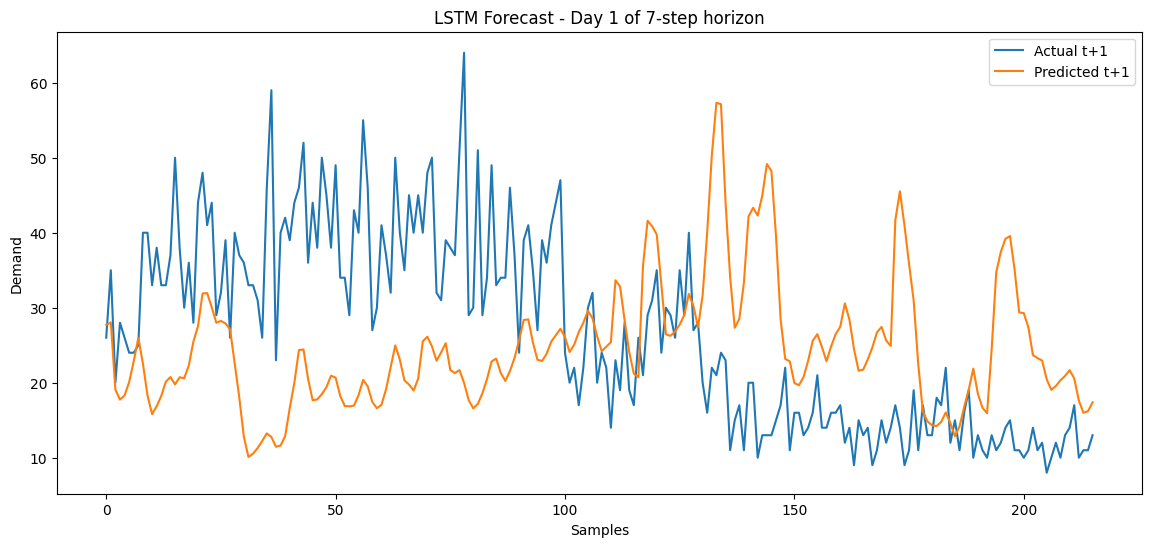

In [43]:
plt.figure(figsize=(14,6))
plt.plot(y_test_actual[:,0], label='Actual t+1')
plt.plot(y_pred[:,0], label='Predicted t+1')
plt.xlabel('Samples')
plt.ylabel('Demand')
plt.title('LSTM Forecast - Day 1 of 7-step horizon')
plt.legend()
plt.show()